In [1]:
import numpy as np
import pandas as pd
import os
from skimage.io import imread
import cv2 as cv
from pathlib import Path
import random
from shutil import copyfile, rmtree
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

/home/kuba/miniconda3/envs/sym_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
softmax = torch.nn.Softmax(dim=1)
device = torch.device("cuda")
device

device(type='cuda')

In [3]:
def load_train_data(input_dir, newSize=(64,64)):
    image_dir = Path(input_dir)
    categories_name = []
    for file in os.listdir(image_dir):
        d = os.path.join(image_dir, file)
        if os.path.isdir(d):
            categories_name.append(file)

    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]

    train_img = []
    categories_count=[]
    labels=[]
    for i, direc in enumerate(folders):
        count = 0
        for obj in direc.iterdir():
            if os.path.isfile(obj) and os.path.basename(os.path.normpath(obj)) != 'desktop.ini':
                labels.append(os.path.basename(os.path.normpath(direc)))
                count += 1
                img = imread(obj)#zwraca ndarry postaci xSize x ySize x colorDepth
                img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)# zwraca ndarray
                img = img / 255#normalizacja
                train_img.append(img)
        categories_count.append(count)

    X={}
    X["values"] = np.array(train_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X

In [4]:
def load_test_data(input_dir, newSize=(64,64)):
    image_path = Path(input_dir)

    labels_path = image_path.parents[0] / 'test_labels.json'

    #with labels_path.open("r", encoding ="utf-8") as f:
    jsonString = labels_path.read_text()
    objects = json.loads(jsonString)

    #print(objects)

    categories_name = []
    categories_count=[]
    count = 0
    c = objects[0]['value']
    for e in  objects:
        if e['value'] != c:
            #print(count)
            #print(c)
            categories_count.append(count)
            c = e['value']
            count = 1
        else:
            count += 1
        if not e['value'] in categories_name:
            categories_name.append(e['value'])

    categories_count.append(count)



    test_img = []

    labels=[]
    for e in objects:
        p = image_path / e['filename']
        img = imread(p)#zwraca ndarry postaci xSize x ySize x colorDepth
        img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)# zwraca ndarray
        img = img / 255#normalizacja
        test_img.append(img)
        labels.append(e['value'])


    X={}
    X["values"] = np.array(test_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X

In [5]:
torch.cuda.empty_cache() 

In [27]:
data_size = int(224)

data_train = load_train_data("train_test_sw/train_sw",newSize=(data_size,data_size))
X_train = data_train['values']
y_train = data_train['labels']


data_test = load_test_data("train_test_sw/test_sw",newSize=(data_size,data_size))
X_test = data_test['values']
y_test = data_test['labels']

class_le = LabelEncoder()
y_train_enc = class_le.fit_transform(y_train)
y_test_enc = class_le.fit_transform(y_test)

X_train = X_train[...,:3]
X_test = X_test[...,:3]

X_train = np.transpose(X_train, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))

number_of_features = X_train.shape[1]
number_of_classes = 5
batch_size = 32

In [7]:
class VGG(nn.Module):
    def __init__(
        self, features: nn.Module, num_classes: int = 1000, init_weights: bool = True, dropout: float = 0.5
    ) -> None:
        super().__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [8]:
class VGG16(nn.Module):
    def __init__(
        self, num_classes: int = 1000, init_weights: bool = True, dropout: float = 0.5
    ) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [9]:
from torch.utils.data import Dataset


class CustomTensorDataset(Dataset):
    def __init__(self, tensors):
        self.tensors = tensors

    def __getitem__(self, index):
        x = self.tensors[0][index]
        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].shape[0]

In [10]:
X_train.shape

(1027, 3, 56, 56)

In [28]:
dataset = CustomTensorDataset((X_train, y_train_enc))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = CustomTensorDataset((X_test, y_test_enc))
test_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [12]:
model = VGG16().to(device=device)
criterion = torch.nn.CrossEntropyLoss(reduction="mean")
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0009)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=0.00001)

In [13]:
costs = []
train_acc = []
test_acc = []

In [14]:
X_test.shape

(259, 3, 56, 56)

In [15]:
test_acc = []
 
def test(epoch):
  model.eval()
  correct=0
  total=0

  with torch.no_grad():
    for i, (imgs, labels) in enumerate(test_dataloader):
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs.float())

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
      del imgs, labels, outputs
  acc = correct/total
  test_acc.append(acc)
 
  print('Test Accuracy: %.3f'%(acc))

  return acc

In [16]:
train_acc = []
train_loss = []

def train(epoch):
  print('\nEpoch : %d'%epoch)
   
  model.train()
 
  running_loss=0
  correct=0
  total=0

  for i, (imgs, labels) in enumerate(dataloader):
    #move tensors to device
    imgs = imgs.to(device)
    labels = labels.to(device)

    #Forward pass
    outputs = model(imgs.float())
    loss = criterion(outputs, labels)

    #Bacward & opt
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    #
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

  loss = running_loss/len(dataloader)
  acc = correct/total

  train_acc.append(acc)
  train_loss.append(loss)
  print('Train Accuracy: %.3f | Loss: %.3f'%(acc, loss))

  scheduler.step()

  return acc, loss

In [17]:
total_step = len(dataloader)

vgg_train_acc = []
vgg_train_loss = []
vgg_test_acc = []

for epoch in range(100):
    tr_acc, tr_loss = train(epoch)
    vgg_test_acc.append(test(epoch))
    vgg_train_acc.append(tr_acc)
    vgg_train_loss.append(tr_loss)


Epoch : 0
Train Accuracy: 0.213 | Loss: 7.228
Test Accuracy: 0.201

Epoch : 1
Train Accuracy: 0.295 | Loss: 1.599
Test Accuracy: 0.245

Epoch : 2
Train Accuracy: 0.307 | Loss: 1.513
Test Accuracy: 0.354

Epoch : 3
Train Accuracy: 0.318 | Loss: 1.462
Test Accuracy: 0.307

Epoch : 4
Train Accuracy: 0.308 | Loss: 1.423
Test Accuracy: 0.353

Epoch : 5
Train Accuracy: 0.373 | Loss: 1.348
Test Accuracy: 0.415

Epoch : 6
Train Accuracy: 0.398 | Loss: 1.222
Test Accuracy: 0.439

Epoch : 7
Train Accuracy: 0.395 | Loss: 1.203
Test Accuracy: 0.436

Epoch : 8
Train Accuracy: 0.448 | Loss: 1.151
Test Accuracy: 0.478

Epoch : 9
Train Accuracy: 0.453 | Loss: 1.158
Test Accuracy: 0.475

Epoch : 10
Train Accuracy: 0.403 | Loss: 1.250
Test Accuracy: 0.384

Epoch : 11
Train Accuracy: 0.444 | Loss: 1.176
Test Accuracy: 0.488

Epoch : 12
Train Accuracy: 0.461 | Loss: 1.186
Test Accuracy: 0.416

Epoch : 13
Train Accuracy: 0.468 | Loss: 1.187
Test Accuracy: 0.540

Epoch : 14
Train Accuracy: 0.541 | Loss: 0.

In [18]:
torch.save(model.state_dict(), "./model_params/vgg16")

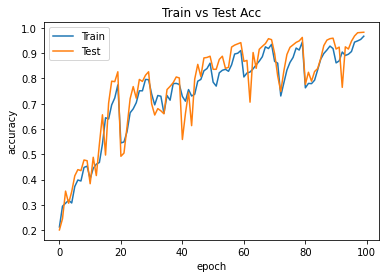

In [19]:
plt.plot(vgg_train_acc)
plt.plot(vgg_test_acc)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["Train", "Test"])
plt.title("Train vs Test Acc")

plt.show()

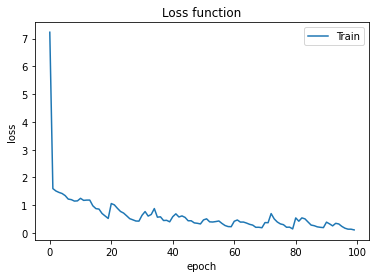

In [20]:
plt.plot(vgg_train_loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Train"])
plt.title("Loss function")

plt.show()

# ResNet

In [21]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [22]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [29]:
model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)
criterion = torch.nn.CrossEntropyLoss(reduction="mean")
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0009)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=0.00001)

In [30]:
total_step = len(dataloader)

resnet_train_acc = []
resnet_train_loss = []
resnet_test_acc = []

for epoch in range(100):
    tr_acc, tr_loss = train(epoch)
    resnet_test_acc.append(test(epoch))
    resnet_train_acc.append(tr_acc)
    resnet_train_loss.append(tr_loss)


Epoch : 0
Train Accuracy: 0.559 | Loss: 1.312
Test Accuracy: 0.201

Epoch : 1
Train Accuracy: 0.727 | Loss: 0.766
Test Accuracy: 0.592

Epoch : 2
Train Accuracy: 0.757 | Loss: 0.645
Test Accuracy: 0.556

Epoch : 3
Train Accuracy: 0.789 | Loss: 0.503
Test Accuracy: 0.591

Epoch : 4
Train Accuracy: 0.842 | Loss: 0.397
Test Accuracy: 0.844

Epoch : 5
Train Accuracy: 0.866 | Loss: 0.345
Test Accuracy: 0.902

Epoch : 6
Train Accuracy: 0.894 | Loss: 0.280
Test Accuracy: 0.878

Epoch : 7
Train Accuracy: 0.913 | Loss: 0.223
Test Accuracy: 0.951

Epoch : 8
Train Accuracy: 0.931 | Loss: 0.178
Test Accuracy: 0.928

Epoch : 9
Train Accuracy: 0.949 | Loss: 0.136
Test Accuracy: 0.970

Epoch : 10
Train Accuracy: 0.854 | Loss: 0.409
Test Accuracy: 0.570

Epoch : 11
Train Accuracy: 0.813 | Loss: 0.488
Test Accuracy: 0.704

Epoch : 12
Train Accuracy: 0.886 | Loss: 0.354
Test Accuracy: 0.763

Epoch : 13
Train Accuracy: 0.873 | Loss: 0.367
Test Accuracy: 0.771

Epoch : 14
Train Accuracy: 0.896 | Loss: 0.

In [31]:
torch.save(model.state_dict(), "./model_params/resnet")

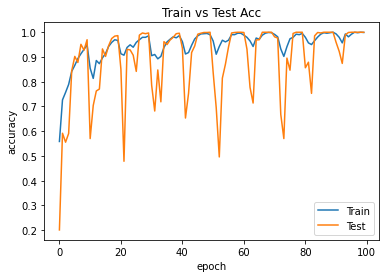

In [32]:
plt.plot(resnet_train_acc)
plt.plot(resnet_test_acc)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["Train", "Test"])
plt.title("Train vs Test Acc")

plt.show()

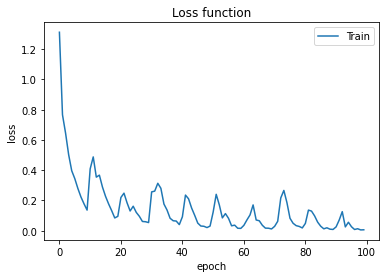

In [33]:
plt.plot(resnet_train_loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Train"])
plt.title("Loss function")

plt.show()